## Описание задачи
Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.  

Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный аппарат.  

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки. 
  

Данные состоят из файлов, полученных из разных источников:  
data_arc.csv - данные об электродах;  
data_bulk.csv - данные о подаче сыпучих материалов (объём);  
data_bulk_time.csv - данные о подаче сыпучих материалов (объём);  
data_gas.csv - данные о продувке сплава газом;  
data_temp.csv - результаты измерения температуры;  
data_wire.csv - данные о проволочных материалах (объём);  
data_wire_time.csv - данные о проволочных материалах (время).  

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

### 1. Загрузка и обработка данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
from tqdm import notebook
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

Прочтем данные. Для удобства (и по традиции) переименуем столбцы, а дату-время приведем к формату datetime.

In [2]:
arc = pd.read_csv('/datasets/final_steel/data_arc.csv',
                 parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [3]:
arc.duplicated().sum()

0

Добавим столбцы с временем для каждого нагрева и с соотношением активная/реактивная мощность.

In [4]:
arc.columns = ['key', 'arc_begin', 'arc_end', 'act_power', 'react_power']
arc['arc_time'] = arc['arc_end'] - arc['arc_begin']
arc['ratio'] = arc['act_power'] / arc['react_power']
arc.head()

,key,arc_begin,arc_end,act_power,react_power,arc_time,ratio
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,00:03:48,1.420582
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,00:03:05,1.548395
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,00:02:52,1.492292
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,00:06:05,1.561504
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,00:02:28,1.671717


Создадим новый датасет, где подготовим признаки: суммарное время нагрева каждой партии, количество нагревов, среднее соотношение act/react для каждой партии.

In [5]:
time_sum = arc.groupby('key').agg({'arc_time': np.sum})
time_sum.rename({'arc_time': 'time_sum'}, axis=1, inplace=True)
num = arc.groupby('key').count()['arc_time']
num.name = 'num'
mean_ratio = arc.groupby('key').mean()['ratio']
mean_ratio.head()
arc_batch = time_sum.join([num, mean_ratio])

arc_batch

,time_sum,num,ratio
key,,,
1,00:18:18,5,1.538898
2,00:13:31,4,1.551834
3,00:10:55,5,1.583120
4,00:12:21,4,1.563487
5,00:14:29,4,1.480428
...,...,...,...
3237,00:15:09,5,1.384203
3238,00:09:06,3,1.257794
3239,00:20:16,8,1.497918


Читаем следующий датасет.

In [6]:
bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [7]:
bulk.duplicated().sum()

0

NaN-ы говорят о том, что такие добавки не засыпались в данную партию, логично заменить их нулями. Также переименовываем столбцы.

In [8]:
columns_new=['key']
for i in range(1,16):
    column = 'bulk'+'_'+str(i)
    columns_new.append(column)

bulk.columns = columns_new
bulk = bulk.fillna(0)
bulk.index = bulk['key']
bulk = bulk.drop('key',axis=1)
bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
bulk_1     3129 non-null float64
bulk_2     3129 non-null float64
bulk_3     3129 non-null float64
bulk_4     3129 non-null float64
bulk_5     3129 non-null float64
bulk_6     3129 non-null float64
bulk_7     3129 non-null float64
bulk_8     3129 non-null float64
bulk_9     3129 non-null float64
bulk_10    3129 non-null float64
bulk_11    3129 non-null float64
bulk_12    3129 non-null float64
bulk_13    3129 non-null float64
bulk_14    3129 non-null float64
bulk_15    3129 non-null float64
dtypes: float64(15)
memory usage: 391.1 KB


Смотрим дальше.

In [9]:
bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Время засыпки в нашей модели мы учитывать не будем, эти данные не используются.  
Читаем данные дальше.

In [10]:
gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [11]:
gas.duplicated().sum()

0

Преобразуем key в индекс.

In [12]:
gas.rename(columns={'Газ 1': 'gas'}, inplace=True)
gas.index = gas['key']
gas = gas.drop('key',axis=1)

Открываем следующий файл.

In [13]:
temp = pd.read_csv('/datasets/final_steel/data_temp.csv', parse_dates=['Время замера'])
temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [14]:
temp.tail(50)

,key,Время замера,Температура
15857,3232,2019-08-31 19:55:53,1563.0
15858,3232,2019-08-31 20:02:31,NaN
15859,3232,2019-08-31 20:11:52,NaN
15860,3232,2019-08-31 20:16:40,NaN
15861,3232,2019-08-31 20:17:12,NaN
15862,3233,2019-08-31 20:24:14,1597.0
15863,3233,2019-08-31 20:30:28,NaN
15864,3233,2019-08-31 20:41:58,NaN
15865,3233,2019-08-31 20:47:24,NaN
15866,3234,2019-08-31 20:54:17,1614.0


В конечной части датасета нет финальных (и промежуточных) температур, только начальные. Количество неизвестных конечных значений составляет около четверти(!!!) от общего числа партий. Вероятно, что-то с датчиками, это вопрос к технической службе. Т.к. финальная температура - это наш таргет, мы никак не можем её восстановить (нам её же и предсказывать). Придется удалять, работаем с тем, что имеем.

In [15]:
temp.duplicated().sum()

0

In [16]:
temp.columns = ['key','measurement_time', 'temp']
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key                 15907 non-null int64
measurement_time    15907 non-null datetime64[ns]
temp                13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


Создадим новый датафрейм с признаками для партий. Столбцами будут: интервал между первым и последним замером температуры для каждой партии и температура первого и последнего замера.  first() и last() не работают с NaN-ами, поэтому заменим их нулями.

In [17]:
temp['temp'] = temp['temp'].fillna(0)

first_time = temp.sort_values('measurement_time').groupby('key').first()['measurement_time']
last_time = temp.sort_values('measurement_time').groupby('key').last()['measurement_time']
time_interval = last_time - first_time
time_interval.name = 'time_interval'

init_temp = temp.sort_values('measurement_time').groupby('key').first()['temp']
init_temp.name = 'init_temp'
final_temp = temp.sort_values('measurement_time').groupby('key').last()['temp']
final_temp.name = 'final_temp'

temp_batch = pd.DataFrame(time_interval).join([init_temp, final_temp])
temp_batch = temp_batch.query('final_temp!=0')
temp_batch

,time_interval,init_temp,final_temp
key,,,
1,00:14:21,1571.0,1613.0
2,00:21:45,1581.0,1602.0
3,00:21:40,1596.0,1599.0
4,00:06:28,1601.0,1625.0
5,00:12:42,1576.0,1602.0
...,...,...,...
2495,00:18:57,1570.0,1591.0
2496,00:26:58,1554.0,1591.0
2497,00:11:57,1571.0,1589.0


Читаем далее.

In [18]:
wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [19]:
wire.duplicated().sum()

0

Переименовываем столбцы. NaN-ы так же, как и в сыпучих добавках заменяем на нули. Меняем индекс.  
Соединяем данные в финальную таблицу.

In [20]:
columns_new=['key']
for i in range(1,10):
    column = 'wire'+'_'+str(i)
    columns_new.append(column)

wire.columns = columns_new
wire = wire.fillna(0)
wire.index = wire['key']
wire = wire.drop('key',axis=1)

final_table = arc_batch.join([bulk, gas, wire, temp_batch])
final_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 31 columns):
time_sum         3214 non-null timedelta64[ns]
num              3214 non-null float64
ratio            3214 non-null float64
bulk_1           3128 non-null float64
bulk_2           3128 non-null float64
bulk_3           3128 non-null float64
bulk_4           3128 non-null float64
bulk_5           3128 non-null float64
bulk_6           3128 non-null float64
bulk_7           3128 non-null float64
bulk_8           3128 non-null float64
bulk_9           3128 non-null float64
bulk_10          3128 non-null float64
bulk_11          3128 non-null float64
bulk_12          3128 non-null float64
bulk_13          3128 non-null float64
bulk_14          3128 non-null float64
bulk_15          3128 non-null float64
gas              3212 non-null float64
wire_1           3080 non-null float64
wire_2           3080 non-null float64
wire_3           3080 non-null float64
wire_4           3080 non-n

In [21]:
wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Этот датасет с временем также не используем.  

Наш целевой признак - финальная температура (final_temp) и этих значений меньше всего. Остальные NaN-ы возникли из-за несовпадения партий при склейке, но их не очень много относительно общего кол-ва значений. Режем.

In [22]:
final_table = final_table.dropna()
final_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 31 columns):
time_sum         2329 non-null timedelta64[ns]
num              2329 non-null float64
ratio            2329 non-null float64
bulk_1           2329 non-null float64
bulk_2           2329 non-null float64
bulk_3           2329 non-null float64
bulk_4           2329 non-null float64
bulk_5           2329 non-null float64
bulk_6           2329 non-null float64
bulk_7           2329 non-null float64
bulk_8           2329 non-null float64
bulk_9           2329 non-null float64
bulk_10          2329 non-null float64
bulk_11          2329 non-null float64
bulk_12          2329 non-null float64
bulk_13          2329 non-null float64
bulk_14          2329 non-null float64
bulk_15          2329 non-null float64
gas              2329 non-null float64
wire_1           2329 non-null float64
wire_2           2329 non-null float64
wire_3           2329 non-null float64
wire_4           2329 non-n

Проверка данных на нормальность в данном случае не совсем уместна, т.к мы не совсем в теме и не знаем, что есть норма. К тому же в случае удаления выбросов модель именно на них будет давать сбой. Тем не менее стоит проверить на разумное соответствие (убедиться, что нет , например, отрицательных значений), что и было сделано (ниже пример для начальной и конечной температур).

Минимальное значение начальной температуры: 1191.0
Максимальное значение начальной температуры: 1660.0


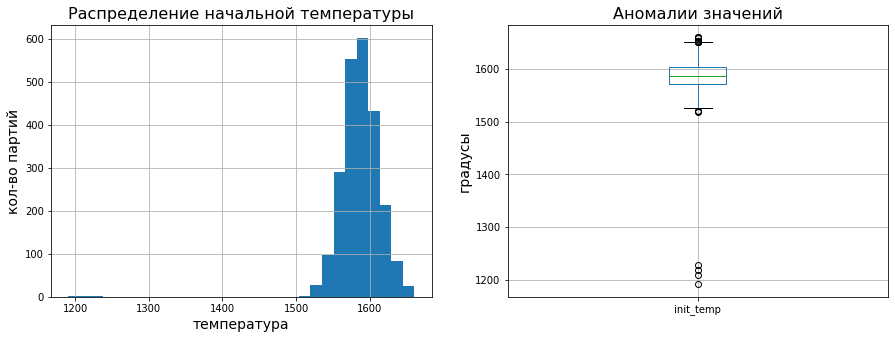

In [23]:
print('Минимальное значение начальной температуры:',final_table['init_temp'].min())
print('Максимальное значение начальной температуры:',final_table['init_temp'].max())

plt.rcParams['figure.figsize'] = [15, 5]

ax = plt.subplot(121)
plt.title('Распределение начальной температуры', size=16)
ax.set_xlabel('температура', size=14)
ax.set_ylabel('кол-во партий', size=14)
final_table['init_temp'].hist(bins=30);

ax = plt.subplot(122)
plt.title('Аномалии значений', size=16)
ax.set_ylabel('градусы', size=14)
pd.DataFrame(final_table['init_temp']).boxplot();

Минимальное значение конечной температуры: 1541.0
Максимальное значение конечной температуры: 1653.0


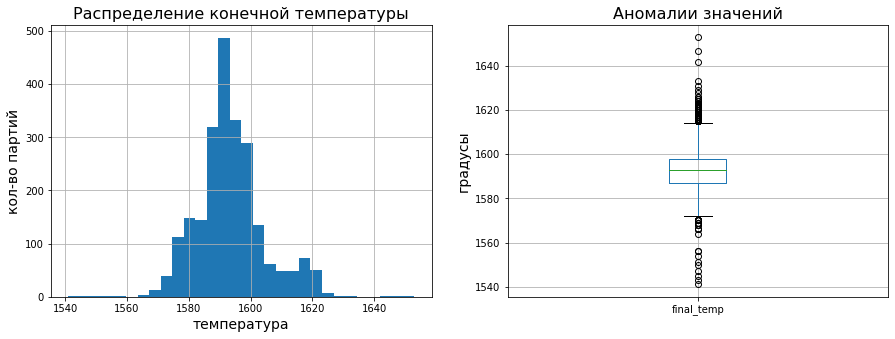

In [24]:
print('Минимальное значение конечной температуры:',final_table['final_temp'].min())
print('Максимальное значение конечной температуры:',final_table['final_temp'].max())

ax = plt.subplot(121)
plt.title('Распределение конечной температуры', size=16)
ax.set_xlabel('температура', size=14)
ax.set_ylabel('кол-во партий', size=14)
final_table['final_temp'].hist(bins=30);

ax = plt.subplot(122)
plt.title('Аномалии значений', size=16)
ax.set_ylabel('градусы', size=14)
pd.DataFrame(final_table['final_temp']).boxplot();

### 2.Построение моделей.

Выделим целевой признак. Время переведем в секунды, т.к. не все модели работают с timedelta.

In [25]:
warnings.filterwarnings('ignore')
final_table['time_sum'] = final_table['time_sum'].dt.total_seconds()
final_table['time_interval'] = final_table['time_interval'].dt.total_seconds()

features = final_table.drop('final_temp', axis=1)
target = final_table['final_temp']



In [26]:
pd.set_option('display.max_columns', 50)
features.head(3)

,time_sum,num,ratio,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,time_interval,init_temp
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1098.0,5.0,1.538898,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,861.0,1571.0
2,811.0,4.0,1.551834,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1305.0,1581.0
3,655.0,5.0,1.583120,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1300.0,1596.0


Посмотрим на корреляцию признаков. Обратим внимание на корреляцию больше 75%.

In [27]:
features.corr()

,time_sum,num,ratio,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,time_interval,init_temp
time_sum,1.000000,0.798897,0.072995,0.103027,0.038213,0.092612,-0.028329,0.013519,0.161907,0.084620,-0.011291,0.012947,-0.005031,0.078171,0.466688,0.129274,0.461335,0.295711,0.396379,0.055419,0.054481,0.033399,0.054803,NaN,0.042288,0.027620,0.017875,-0.011585,0.565081,-0.305086
num,0.798897,1.000000,0.066154,0.097734,0.093070,0.109092,-0.004408,0.075008,0.152614,0.152492,-0.008975,0.038226,0.012659,0.062565,0.306937,0.117722,0.334118,0.174703,0.404036,0.138141,0.078113,0.055257,0.113653,NaN,0.053383,0.073669,0.043898,-0.024577,0.587073,-0.141478
ratio,0.072995,0.066154,1.000000,-0.092187,-0.052880,0.153964,0.015451,-0.025474,0.025098,-0.043568,-0.020649,0.052375,0.023164,-0.022103,0.066644,0.003468,0.142712,0.105101,0.087672,0.129214,0.009337,0.018122,-0.030916,NaN,-0.000617,-0.042688,0.054670,-0.010298,0.005539,-0.070833
bulk_1,0.103027,0.097734,-0.092187,1.000000,0.224701,-0.011628,0.041846,0.060429,-0.003630,0.237213,-0.005725,-0.019756,-0.023187,-0.037892,0.325771,-0.010279,0.207718,-0.000800,0.234141,0.013682,-0.009229,0.020271,0.146301,NaN,0.148561,0.083443,-0.019535,0.011066,0.149989,0.072331
bulk_2,0.038213,0.093070,-0.052880,0.224701,1.000000,-0.046888,0.040792,0.360302,-0.029984,0.679356,-0.001545,-0.005333,-0.018015,0.001479,-0.098962,-0.005592,-0.140952,-0.105693,0.217415,-0.169477,-0.039058,0.223202,0.699342,NaN,0.558889,0.431737,-0.005273,-0.006842,0.250145,0.119802
bulk_3,0.092612,0.109092,0.153964,-0.011628,-0.046888,1.000000,-0.295431,-0.006801,0.065284,-0.033480,0.020824,0.011337,-0.085186,-0.007445,0.018371,-0.013389,0.010772,-0.012860,0.059628,0.039637,0.095723,0.005780,-0.040526,NaN,0.007113,-0.019448,0.004846,0.004621,0.025857,-0.104394
bulk_4,-0.028329,-0.004408,0.015451,0.041846,0.040792,-0.295431,1.000000,0.028348,-0.251562,0.045893,-0.013187,-0.002940,-0.084746,-0.119529,0.105791,0.003209,-0.090602,0.101514,0.017578,0.297591,-0.268142,-0.039219,0.034421,NaN,-0.011417,0.033829,0.007830,-0.058138,0.000188,0.144775
bulk_5,0.013519,0.075008,-0.025474,0.060429,0.360302,-0.006801,0.028348,1.000000,-0.021852,0.288338,-0.002443,-0.008431,-0.028480,-0.015840,-0.072758,-0.008841,-0.065890,-0.067190,0.086902,-0.013493,-0.013794,0.070916,0.262763,NaN,0.204819,0.172141,-0.008337,-0.010817,0.098600,0.068389
bulk_6,0.161907,0.152614,0.025098,-0.003630,-0.029984,0.065284,-0.251562,-0.021852,1.000000,-0.025099,-0.008334,-0.028762,-0.097157,0.196733,-0.112902,0.042632,0.177490,-0.109316,0.139625,-0.235793,0.204627,-0.046518,-0.025915,NaN,-0.020223,-0.012437,-0.028440,-0.013335,0.149048,-0.096951
bulk_7,0.084620,0.152492,-0.043568,0.237213,0.679356,-0.033480,0.045893,0.288338,-0.025099,1.000000,-0.001355,-0.004675,-0.015793,-0.004910,-0.017742,-0.004902,-0.076388,-0.090099,0.198311,-0.143267,-0.000631,0.156626,0.740572,NaN,0.456101,0.372250,-0.004623,-0.005998,0.245321,0.074729


In [28]:
features['wire_5'].unique()

array([0.])

Признак wire_5 состоит из одних нулей - удаляем.  
Признаки num и time_sum - корреляция 80%. num удаляем.  
wire_8 и bulk_9: к-т корреляции 97%. Но эти факторы никак не связаны, полагаю - случайность.  
Разобъем выборку на тренировочную, валидационную и тестовую.

In [29]:
features = features.drop(['num', 'wire_5'], axis=1)

features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

Проведем масштабирование признаков.

In [30]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)


Рассмотрим следующие модели:  
дерево решений, случайный лес, линейная регрессия и 2 модели градиентного бустинга: от Microsoft и от Яндекса.

In [31]:
mae_min = 20
crit_list = ['mse', 'friedman_mse', 'mae']
split_list = ['best', 'random']
for crit in notebook.tqdm(crit_list):
    for split in split_list:
        for depth in range(1, 21, 1):
            model = DecisionTreeRegressor(criterion=crit, splitter=split, random_state=12345, max_depth=depth)
            model.fit(features_train, target_train)
            prediction = model.predict(features_valid)
            mae = mean_absolute_error(target_valid, prediction)
            if mae < mae_min:
                mae_min = mae
                dep = depth
                cr = crit
                spl = split
print('Наименьшее значение MAE -', mae_min, 'при:')
print('max_depth =', dep)
print('splitter =', spl)
print('criterion =', cr)


Наименьшее значение MAE - 6.842667533937232 при:
max_depth = 4
splitter = best
criterion = mse


In [32]:
mae_min = 20
for estim in notebook.tqdm(range(1, 16, 1)):
    for depth in range(1, 21, 1):
        model = RandomForestRegressor(n_estimators=estim, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        prediction = model.predict(features_valid)
        mae = mean_absolute_error(target_valid, prediction)
        if mae < mae_min:
            mae_min = mae
            est = estim
            dep = depth
print('Наименьшее значение MAE -', mae_min, 'при:')
print('n_estimators =', est)
print('max_depth =', dep)


Наименьшее значение MAE - 6.20919790850962 при:
n_estimators = 14
max_depth = 16


In [33]:
model = LinearRegression()
model.fit(features_train, target_train)
prediction = model.predict(features_valid)
print('MAE =',  mean_absolute_error(target_valid, prediction))

MAE = 6.35776566297191


In [34]:
mae_min = 20
lr = 0.1
while lr <= 0.4:
    for depth in notebook.tqdm(range(1, 6, 1)):
        model = LGBMRegressor(
                     learning_rate = lr, 
                     max_depth = depth,
                     metric = 'mae',
                     random_state = 12345, 
                     n_estimators = 500
                                        )

        model.fit(features_train, target_train)
        prediction = model.predict(features_valid)
        mae = mean_absolute_error(target_valid, prediction)
        if mae < mae_min:
            mae_min = mae
            l_r = lr
            dep = depth
    lr += 0.1
    
print('Наименьшее значение MAE -', mae_min, 'при:')
print('learning_rate =', l_r)
print('max_depth =', dep)


Наименьшее значение MAE - 5.7555855282907356 при:
learning_rate = 0.2
max_depth = 1


In [35]:
mae_min = 20
lr = 0.1
while lr <= 0.4:
    for depth in range(1, 6, 1):
        model = CatBoostRegressor(
                     learning_rate = lr, 
                     depth = depth,
                     iterations=500
                                    )

        model.fit(features_train, target_train, verbose=500)
        prediction = model.predict(features_valid)
        mae = mean_absolute_error(target_valid, prediction)
        if mae < mae_min:
            mae_min = mae
            l_r = lr
            dep = depth
    lr += 0.1
    
print('Наименьшее значение MAE -', mae_min, 'при:')
print('learning_rate =', l_r)
print('depth =', dep)

0:	learn: 11.1038021	total: 48.1ms	remaining: 24s
499:	learn: 7.1576014	total: 1.91s	remaining: 0us
0:	learn: 10.9941441	total: 1.47ms	remaining: 734ms
499:	learn: 5.8441920	total: 2.91s	remaining: 0us
0:	learn: 10.9555472	total: 1.7ms	remaining: 850ms
499:	learn: 4.9392989	total: 3.84s	remaining: 0us
0:	learn: 10.9280457	total: 2.66ms	remaining: 1.33s
499:	learn: 4.0709071	total: 4.12s	remaining: 0us
0:	learn: 10.9008623	total: 3.67ms	remaining: 1.83s
499:	learn: 3.3242464	total: 6.43s	remaining: 0us
0:	learn: 11.0191388	total: 647us	remaining: 323ms
499:	learn: 6.6375827	total: 2.16s	remaining: 0us
0:	learn: 10.8084859	total: 803us	remaining: 401ms
499:	learn: 4.9653786	total: 2.88s	remaining: 0us
0:	learn: 10.7333792	total: 1.02ms	remaining: 511ms
499:	learn: 3.8042806	total: 3.83s	remaining: 0us
0:	learn: 10.6793011	total: 1.39ms	remaining: 692ms
499:	learn: 2.8608226	total: 5.19s	remaining: 0us
0:	learn: 10.6254700	total: 1.88ms	remaining: 937ms
499:	learn: 1.8707026	total: 6.68s	

### 3. Тестирование

Сначала оценим границу адекватности модели с помощью среднего.

In [36]:
prediction = pd.Series(target_train.mean(), target_test.index)
mae = mean_absolute_error(target_test, prediction)
print('Константная MAE =', mae)

Константная MAE = 8.324556606584938


Проверим на тестовой выборке две наши лучшие модели: Microsoft vs Яндекс. Для лучшего обучения объединим train и valid.

In [37]:
features_train = pd.concat([pd.DataFrame(features_train), pd.DataFrame(features_valid)])
target_train = pd.concat([target_train, target_valid])

In [38]:
model = LGBMRegressor(
                     learning_rate = 0.2, 
                     max_depth = 1,
                     metric = 'mae',
                     random_state = 12345, 
                     n_estimators = 500
                                        )
model.fit(features_train, target_train)
prediction = model.predict(features_test)
mae = mean_absolute_error(target_test, prediction)
print('Тестовая MAE =', mae)

Тестовая MAE = 5.875873838393156


In [39]:
model = CatBoostRegressor(
                     learning_rate = 0.1, 
                     depth = 4,
                     iterations=500
                                    )
model.fit(features_train, target_train, silent=True)
prediction = model.predict(features_test)
mae = mean_absolute_error(target_test, prediction)
print('Тестовая MAE =', mae)

Тестовая MAE = 5.794753475080376


Победа Яндекса по очкам, его модель предсказывает температуру со средней ошибкой 5.8 градуса.  
Оценим значимость каждого признака для модели.

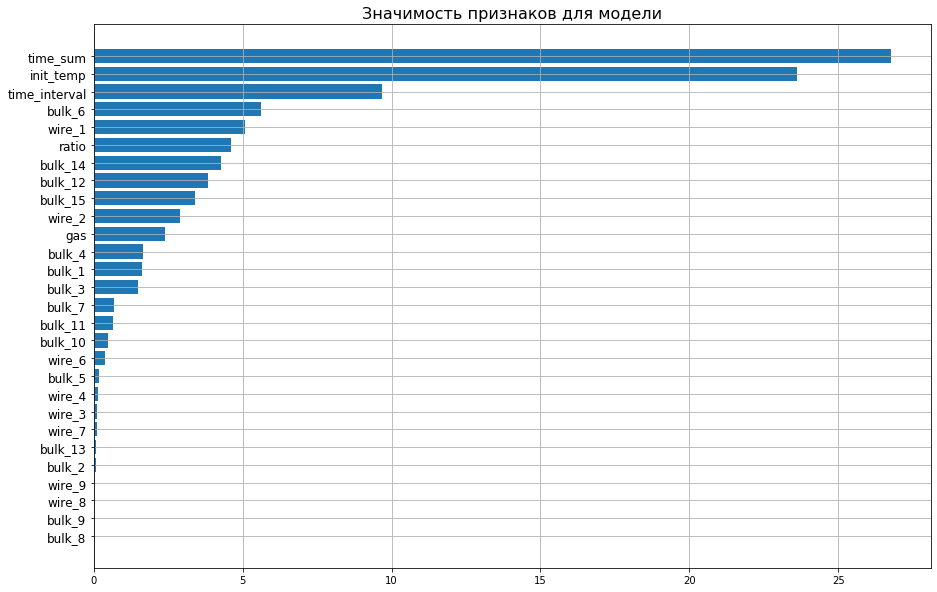

In [40]:
feature_importance = model.feature_importances_
idx = np.argsort(feature_importance)
pos = np.arange(idx.shape[0])
fig = plt.figure(figsize=(15, 10))
plt.barh(pos, feature_importance[idx])
plt.yticks(pos, np.array(features.columns[idx]),size=12)
plt.grid()
plt.title('Значимость признаков для модели', size=16);

18 признаков из 28 можно признать значимыми, остальные не оказывают существенного влияния на работу модели.